# Setup
---

## Module Imports

In [1]:
from treetime.utils import parse_dates
from treetime import TreeTime
from treetime import plot_vs_years

from Bio import Phylo

import random
import copy

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import cm
import matplotlib.ticker as ticker

import seaborn as sns

#from datetime import datetime
import datetime
import pandas as pd
from scipy import stats
import numpy as np

## Input File Paths

In [2]:
meta_path = "../Assembly_Modern/nextstrain/metadata_nextstrain_geocode_state.tsv"
tree_path = "../Assembly_Modern/iqtree/iqtree.core-filter0_bootstrap.treefile"
aln_path = "../Assembly_Modern/snippy_multi/snippy-core.full_CHROM.filter0.fasta"

## Constants and Variables

In [3]:
NO_DATA_CHAR = "?"
OUTGROUP = ["GCA_000323485.1_ASM32348v1_genomic",
            "GCA_000323845.1_ASM32384v1_genomic"]

# Preferred values: slack=1.0, coupling=0.5
slack = 1.0
coupling = 0.5
confidence = 0.95
# Offset for mutations: 0 will be 1-based
offset = 0
# Branch Length Optimization
# For more divergent sequences, iterative optimization will underestimate the branch lengths
# What is "divergent"? treetime data is a lot of epidemic viral phylo, so I think bacterial history is divergent
# Shaw et al. (2019) finds that joint is inappropriate (because topology is fixed), classical marginal is fine?
bl_mode = "input"
ml_mode = "marginal" # Shaw et al. (2019) demonstrate joint is bad
title = "Autocorrelated Relaxed Clock"
file_prefix = "autocorrelated-relaxed-clock"

random.seed(131495)

## Parse Dates

In [4]:
dates = parse_dates(date_file=meta_path, date_col="BioSampleCollectionDate")
dates_rtt = copy.deepcopy(dates)
for sample in dates_rtt:
    # If list range specified, take mean
    if type(dates_rtt[sample]) == type([]):
        date_mean = (dates_rtt[sample][0] + dates_rtt[sample][1]) / 2
        dates_rtt[sample] = date_mean


Attempting to parse dates...
	Using column 'strain' as name. This needs match the taxon names in the tree!!
	Using column 'BioSampleCollectionDate' as date.


## Parse Tree

In [5]:
tree = Phylo.read(tree_path, "newick")
tree_tip_names = [t.name for t in tree.get_terminals()]

# Clock Analysis

## Treetime relaxed clock analysis

In [6]:
tt_relaxed = TreeTime(tree = tree_path,
                      aln = aln_path,
                      verbose = 4,
                      dates = dates)


0.00	-TreeAnc: set-up

75.32	-SequenceData: loaded alignment.

75.32	-SeqData: making compressed alignment...

200.20	-SequenceData: constructed compressed alignment...
225.43	--ClockTree: Setting precision to level 2

225.45	-ClockTree._assign_dates: assigned date contraints to 476 out of 476
      	 tips.


In [7]:
tt_relaxed.run(branch_length_mode = bl_mode,
               n_iqd=3,
               root=None,
               infer_gtr=True,
               resolve_polytomies=False,
               relaxed_clock={"slack":slack, "coupling":coupling},
               max_iter=3,
               Tc="skyline",
               use_covariation=False,
               vary_rate=False,
               time_marginal="assign", # Enable marginal likelihood and final round for error bar estimation
               sequence_marginal=True,
               verbose=4,
              )


225.46	-TreeAnc.infer_ancestral_sequences with method: probabilistic, marginal

225.46	WARNING: Previous versions of TreeTime (<0.7.0) RECONSTRUCTED sequences
      	of tips at positions with AMBIGUOUS bases. This resulted in unexpected
      	behavior is some cases and is no longer done by default. If you want to
      	replace those ambiguous sites with their most likely state, rerun with
      	`reconstruct_tip_states=True` or `--reconstruct-tip-states`.
225.46	--TreeAnc._ml_anc_marginal: type of reconstruction: Marginal
225.46	---Attaching sequence profiles to leafs...
225.95	---Postorder: computing likelihoods...
226.41	---Computing root node sequence and total tree likelihood...
226.43	---Preorder: computing marginal profiles...
227.20	---TreeAnc._ml_anc_marginal: ...done
227.25	--TreeAnc.infer_gtr: counting mutations...
228.55	---TreeAnc.infer_gtr: counting mutations...done

228.55	-GTR: with alphabet: ['A', 'C', 'G', 'T', '-']
228.55	--GTR: ambiguous character: N
228.55	---GTR

269.89	--ClockTree - Marginal reconstruction:  Propagating root -> leaves...
310.11	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
310.11	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
310.11	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
310.12	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
310.12	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
310.12	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
310.12	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
310.12	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"

496.88	---Computing root node sequence and total tree likelihood...
496.88	---Preorder: computing marginal profiles...
497.47	---TreeAnc._ml_anc_marginal: ...done

497.63	###TreeTime.run: FINAL ROUND - confidence estimation via marginal
      	reconstruction

497.63	-ClockTree: Maximum likelihood tree optimization with temporal
      	 constraints
497.63	--ClockTree.init_date_constraints...
497.63	---ClockTree.init_date_constraints: Initializing branch length
      	   interpolation objects...
498.69	--ClockTree.date2dist: Setting new molecular clock. rate=4.348e-08,
      	  R^2=0.0035
498.70	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
      	    excluding it from the optimization process. Date constraint will be
      	    ignored!
498.70	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
      	    excluding it from the optimization process. Date constraint will be
      	    ignored!
498.70	----ClockTree.init_date_constraints -- WA

'success'

## Add Node Comments

In [8]:
for n in tt_relaxed.tree.find_clades():
    # Add mutations comment
    if n.mutations:
        mut_comment = 'mutations="' + ','.join([a+str(pos + offset)+d for (a,pos, d) in n.mutations
                                                              if tt_relaxed.gtr.ambiguous not in [a,d]])+'"'
        if n.comment:
            n.comment = ",".join([n.comment, mut_comment])
        else:
            n.comment = "&" + mut_comment
    # Add date comment
    if n.numdate:
        date_comment = 'date={:.2f}'.format(n.numdate)
        if n.comment:
            n.comment = ",".join([n.comment, date_comment])
        else:
            n.comment = "&" + date_comment


## Plot: Root-To-Tip

### Setup Data

In [18]:
# Create a copy to reset the branch lengths
tt_relaxed_rtt = copy.deepcopy(tt_relaxed)

full_dist2root = []
full_date = []

# Reset branch length from clock length
# If you didn't do this, it would be a perfect regression! Because that's how timetree works
for c in tt_relaxed_rtt.tree.get_terminals():
    c.branch_length = c.mutation_length

# Create a dataframe that does not include the outgroup
for t in tt_relaxed_rtt.tree.get_terminals():
    if t.name not in OUTGROUP:
        full_dist2root.append(tt_relaxed_rtt.tree.distance(tt_relaxed_rtt.tree.root, t))
        # Draw the dates from the dictionary where range converted to mean
        full_date.append(dates_rtt[t.name])

df = pd.DataFrame({
          "dist2root" : full_dist2root,
          "date": full_date
         })

df['date_ordinal'] = pd.to_datetime(df['date']).apply(lambda date: date.toordinal())

0     1970-01-01 00:00:00.000001995
1     1970-01-01 00:00:00.000001998
2     1970-01-01 00:00:00.000001988
3     1970-01-01 00:00:00.000001996
4     1970-01-01 00:00:00.000001984
                   ...             
461   1970-01-01 00:00:00.000002010
462   1970-01-01 00:00:00.000002010
463   1970-01-01 00:00:00.000002010
464   1970-01-01 00:00:00.000002009
465   1970-01-01 00:00:00.000002010
Name: date, Length: 466, dtype: datetime64[ns]


In [21]:
pd.to_datetime(1999, "%Y")

AssertionError: 

### Plot

'\nslope, intercept, r_value, p_value, std_err = stats.linregress(df[\'date_ordinal\'],df[\'dist2root\'])\nprint(r_value)\nax = sns.regplot(x="date_ordinal",\n                       y="dist2root",\n                       data=df,\n                       ci=90,\n                       line_kws={\'label\':"r2={0:.2f}".format(r_value)})\n                       #line_kws={\'label\':"y={0:.2f}x+{1:.2f}".format(slope,intercept)})\n\nax.set_xlim(df[\'date_ordinal\'].min() - 1000, df[\'date_ordinal\'].max() + 1000)\nax.set_xlabel(\'Date\')\nax.set_ylabel(\'Distance to Root\')\n\nnew_labels = [datetime.date.fromordinal(int(item)).year for item in ax.get_xticks()]\nax.set_xticklabels(new_labels)\n#ax.yaxis.set_major_locator(ticker.MultipleLocator(0.0001))\n# plot legend\nax.legend()\n\nax.set_title("Root To Tip Regression)".format(title, slack, coupling))\nplt.savefig("{}_rtt.png".format(file_prefix), dpi=400, bbox_inches = "tight")\n'

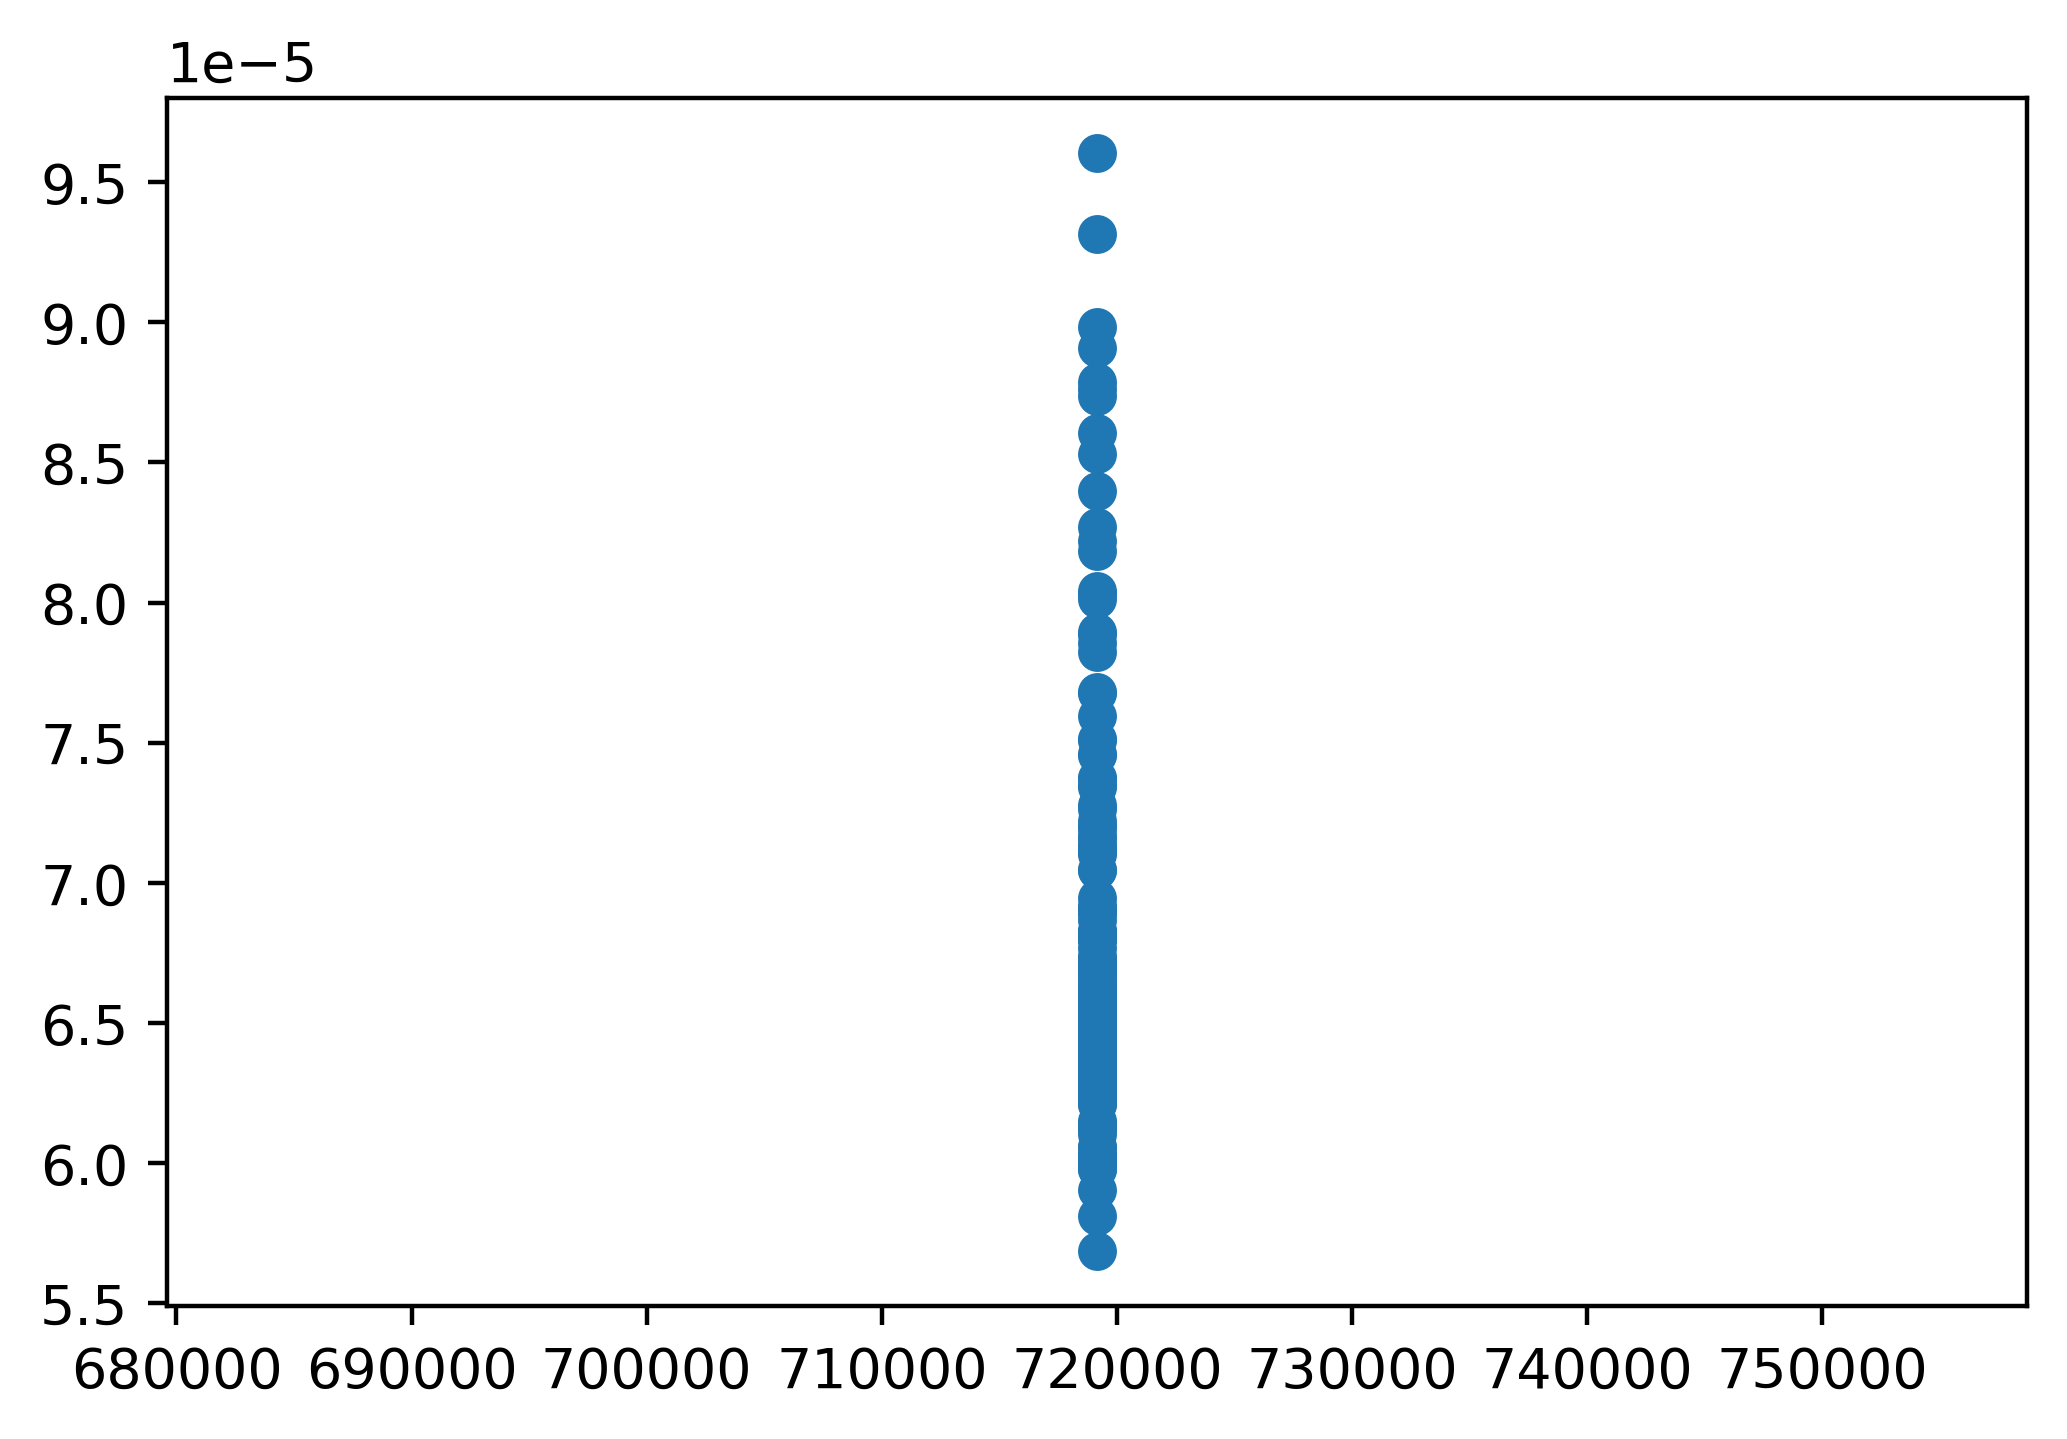

In [12]:
plt.figure(dpi=400)
points = plt.scatter(x=df['date_ordinal'], 
                    y=df['dist2root'])

"""
slope, intercept, r_value, p_value, std_err = stats.linregress(df['date_ordinal'],df['dist2root'])
print(r_value)
ax = sns.regplot(x="date_ordinal",
                       y="dist2root",
                       data=df,
                       ci=90,
                       line_kws={'label':"r2={0:.2f}".format(r_value)})
                       #line_kws={'label':"y={0:.2f}x+{1:.2f}".format(slope,intercept)})

ax.set_xlim(df['date_ordinal'].min() - 1000, df['date_ordinal'].max() + 1000)
ax.set_xlabel('Date')
ax.set_ylabel('Distance to Root')

new_labels = [datetime.date.fromordinal(int(item)).year for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
#ax.yaxis.set_major_locator(ticker.MultipleLocator(0.0001))
# plot legend
ax.legend()

ax.set_title("Root To Tip Regression)".format(title, slack, coupling))
plt.savefig("{}_rtt.png".format(file_prefix), dpi=400, bbox_inches = "tight")
"""

## Node-Dating

### Setup Data

In [ ]:
# Ancient Root Node
# Spyrou et al. (2019) 5727y BP (HPD 95%: 4909–6842)

## Modern Root Node - MRCA of outgroup nodes and anything else ('Reference' will always be present)
# Rascovan et al. : 5135 YBP (-3115)
# Spyrou et al. (2019) : 5237 YBP ()
root_node_calib = 1950 - 5237
root_node = tt_relaxed.tree.root
root_node_conf = tt_relaxed.get_max_posterior_region(root_node, fraction=confidence)
print("root_node: ")
print("\tnumdate: ", root_node.numdate)
print("\tconf: ", root_node_conf)
print("\tcalib: ", root_node_calib)
print("\n")

# RT5 Node, Polytomy of 0.PE2 (n=20, FSU), 0.PE4 (n=2, China), (n=13, China, FSU)
# Spyrou et al. 4011y BP (HPD 95%: 3760–4325)
# 3 nodes: 0.PE4 (n=2) and Reference (CO92)
rt_node_calib = 1950 - 4011
rt_node = tt_relaxed.tree.common_ancestor(["GCA_000320425.1_ASM32042v1_genomic","GCA_000323625.1_ASM32362v1_genomic", "Reference"])
rt_node_conf = tt_relaxed.get_max_posterior_region(rt_node, fraction=confidence)
print("rt_node: ")
print("\tnumdate: ", rt_node.numdate)
print("\tconf: ", rt_node_conf)
print("\tcalib: ", rt_node_calib)
print("\n")

# Justinian Node
# 3 nodes, Ulgeica (Mongolia) and Reference (CO92)
just_node_calib = 2020 - 1959
just_node_before = tt_relaxed.tree.common_ancestor(["GCA_006546725.1_ASM654672v1_genomic", "GCA_006517425.1_ASM651742v1_genomic", "Reference"])
just_node_before_conf = tt_relaxed.get_max_posterior_region(just_node_before, fraction=confidence)
just_node_after = tt_relaxed.tree.common_ancestor(["GCA_000323665.1_ASM32366v1_genomic", "GCA_000324185.1_ASM32418v1_genomic", "Reference"])
just_node_after_conf = tt_relaxed.get_max_posterior_region(just_node_after, fraction=confidence)
just_node_date = (just_node_after_conf[1] + just_node_before_conf[0]) /2

print("just_node: ")
print("\tnumdate: ", just_node_date)
print("\tconf: ", [just_node_before_conf[0],just_node_after_conf[1]])
print("\tcalib: ", just_node_calib)
print("\n")

## Big Bang (Black Death) Node
# Spyrou et al. (2019) : 754 YBP
# 2 nodes: A Medievalis strain (C-791) and Reference (CO92)
bd_node_calib = 1950 - 754
bd_node = tt_relaxed.tree.common_ancestor(["GCA_001617705.1_Yersinia_pestis_C-791_genomic", "Reference"])
bd_node_conf = tt_relaxed.get_max_posterior_region(bd_node, fraction=confidence)
print("bd_node: ")
print("\tnumdate: ", bd_node.numdate)
print("\tconf: ", bd_node_conf)
print("\tcalib: ", bd_node_calib)
print("\n")

# Modern 
# 3 nodes, India195, Indonesia, Reference (CO92)
modern_node_calib = 1894
modern_node =  tt_relaxed.tree.common_ancestor(["GCA_000182505.1_ASM18250v1_genomic", "GCA_000834905.1_ASM83490v1_genomic", "Reference"])
modern_node_conf = tt_relaxed.get_max_posterior_region(modern_node, fraction=confidence)
print("modern_node: ")
print("\tnumdate: ", modern_node.numdate)
print("\tconf: ", modern_node_conf)
print("\tcalib: ", modern_node_calib)
print("\n")

## Reference Node
ref_node = tt_relaxed.tree.common_ancestor("Reference")

# Scatter plot of node dates
list_node_name = ["Modern Root", "RT5", "Justinian", "Black Death", "Modern Pandemic"]
list_calib_date = [root_node_calib, rt_node_calib, just_node_calib, bd_node_calib, modern_node_calib]
list_estimate_date = [root_node.numdate, rt_node.numdate, just_node_date, bd_node.numdate, modern_node.numdate]
list_lower_conf = [root_node_conf[0], rt_node_conf[0], just_node_before_conf[0], bd_node_conf[0], modern_node_conf[0]]
list_upper_conf = [root_node_conf[1], rt_node_conf[1], just_node_after_conf[1], bd_node_conf[1], modern_node_conf[1]]

# Lists for error bar calculations
list_lower_diff = []
list_upper_diff = []

zip_estimate_lower = zip(list_estimate_date, list_lower_conf)
for list1_i, list2_i in zip_estimate_lower:
    list_lower_diff.append(list1_i-list2_i)
    
zip_estimate_upper = zip(list_upper_conf, list_estimate_date)
for list1_i, list2_i in zip_estimate_upper:
    list_upper_diff.append(list1_i-list2_i)

### Plot

In [ ]:
plt.figure(dpi=400)
ax = plt.subplot()

# Confidence Interval
plt.errorbar(
    x=list_node_name,
    y=list_estimate_date,
    yerr=[list_lower_diff, list_upper_diff],
    linestyle='',
    c="#e41a1c",
    label="{0:.0f}% Confidence Interval (marginal)".format(confidence * 100),
)

# Sampling date scatter plot
scatter_sample = plt.scatter(x=list_node_name, y=list_calib_date, c="#377eb8", label = "Publication Date")

# Estimated date scatter plot
plt.scatter(x=list_node_name, y=list_estimate_date, c="#e41a1c", label = "Estimated Date ({})".format(ml_mode), )

#perc_string = "{0:.0f}% of confidence intervals \ncontain sampling date".format(perc_ci_contain_sample_date)
                                                                                
# Add text
#plt.text(1.05, 0.5, 
#         perc_string, 
#         horizontalalignment='left', 
#         verticalalignment='center', 
#         transform=ax.transAxes)

# Formatting
plt.xticks(rotation=90)
plt.grid(True)

# Place a legend to the right of this smaller subplot.
legend1 = plt.legend(handles=scatter_sample.legend_elements()[0],
                     labels= [""],
                     bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


#plt.gca().add_artist(legend1)
# Title
plt.title("{}\n(slack={:.1f}; coupling={:.1f})".format(title, slack, coupling))
plt.savefig("{}_note-dating.png".format(file_prefix), dpi=400, bbox_inches = "tight")

## Skyline

In [ ]:
skyline, conf = tt_relaxed.merger_model.skyline_inferred(gen=50, confidence=2)

plt.figure(dpi=400)
fig = plt.figure()
ax = plt.subplot()

plt.fill_between(skyline.x, conf[0], conf[1], color=(0.8, 0.8, 0.8))
plt.plot(skyline.x, skyline.y, label='maximum likelihood skyline')
plt.yscale('log')
plt.legend()
plt.ticklabel_format(axis='x',useOffset=False)

ax.set_title("{}\n(slack={:.1f}; coupling={:.1f})".format(title, slack, coupling))
plt.savefig("{}_skyline.png".format(file_prefix), dpi=400)

## Stats

In [ ]:
# Dates Confidence File Header
fh_dates = open("{}_dates.tsv".format(file_prefix), 'w', encoding='utf-8')
fh_dates.write('#Lower and upper bound delineate the {0:.0f}% max posterior region\n'.format(confidence*100))
fh_dates.write('#node\tdate\tnumeric date\tlower bound\tupper bound\n')

for n in tt_relaxed.tree.find_clades():
    if n.bad_branch:
        fh_dates.write('%s\t--\t--\t--\t--\n'%(n.name))
    else:
        conf = tt_relaxed.get_max_posterior_region(n, fraction=confidence) 
        fh_dates.write('%s\t%s\t%f\t%f\t%f\n'%(n.name, n.date, n.numdate,conf[0], conf[1]))
#--------------

# Substition File Header
fh_rates = open("{}_rates.tsv".format(file_prefix), 'w')
fh_rates.write("#node\tclock_length\tmutation_length\trate\tfold_change\n")

for n in tt_relaxed.tree.find_clades(order="preorder"):
    if n==tt_relaxed.tree.root:
        continue
    g = n.branch_length_interpolator.gamma
    fh_rates.write("%s\t%1.3e\t%1.3e\t%1.3e\t%1.2f\n"%(n.name, n.clock_length, n.mutation_length, tt_relaxed.date2dist.clock_rate*g, g))